In [1]:
import pyfesom2 as pf
import xarray as xr
import cmocean
from matplotlib import cm
import datetime
from scipy.spatial import cKDTree


import numpy as np
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import matplotlib.colors as colors

import dask
from dask.distributed import Client
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}proxy/{port}/status'})

import os
import shutil
import glob
from collections import defaultdict

from matplotlib.colors import  BoundaryNorm

%matplotlib inline

osgeo is not installed, conversion to Geo formats like Geotiff (fesom2GeoFormat) will not work.


In [2]:
#paths 
data_path = '/p/scratch/chhb19/mueller29/AO_40_nopc/'
mesh_path = '/p/project/chhb19/meshes/AO_40/'
itp_path = '/p/project/chhb19/mueller29/mat_files/ITP_WHOI/'
plot_path  = '/p/home/jusers/mueller29/juwels/EPICA/plots/model_evaluation/'




In [69]:
reg_eeb = [95, 145, 76, 87.5]
reg_web = [-10, 95, 80, 87.5]

In [27]:
n_cores = 40
mem_lim = str(int(np.floor(95/n_cores)))+'GB'
if 'client' in locals() or 'client' in globals():
    client.close()
client = Client(n_workers=n_cores, threads_per_worker=1,memory_limit=mem_lim)
client.amm.start() #automatic memory management
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/vasco.mueller_at_awi.de/r0b111d10d9c453583df569be68e9959/proxy/8787/status,
Dashboard: /user/vasco.mueller_at_awi.de/r0b111d10d9c453583df569be68e9959/proxy/8787/status,Workers: 40
Total threads: 40,Total memory: 74.51 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37085,Workers: 40
Dashboard: /user/vasco.mueller_at_awi.de/r0b111d10d9c453583df569be68e9959/proxy/8787/status,Total threads: 40
Started: Just now,Total memory: 74.51 GiB
Comm: tcp://127.0.0.1:38031,Total threads: 1
Dashboard: /user/vasco.mueller_at_awi.de/r0b111d10d9c453583df569be68e9959/proxy/34335/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:46297,


In [5]:
def decimal_day_to_date(year, decimal_day):
    # Calculate the ordinal day (whole number part)
    ordinal_day = int(decimal_day)
    year = int(year)
    # Calculate the time within the day in seconds (integer)
    time_within_day_seconds = int((decimal_day - ordinal_day) * 24 * 3600)
    
    # Calculate the datetime for the given year and ordinal day
    date = datetime.datetime(year, 1, 1) + datetime.timedelta(days=ordinal_day - 1)
    
    # Add the time within the day to the datetime
    date += datetime.timedelta(seconds=time_within_day_seconds)
    
    return date

def discrete_cmap(N, base_cmap=None):
    from matplotlib.colors import LinearSegmentedColormap
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    #return base.from_list(cmap_name, color_list, N)
    return LinearSegmentedColormap.from_list(cmap_name, color_list, N)

def lon_lat_to_cartesian(lon, lat, R=6371000):
    """
    calculates lon, lat coordinates of a point on a sphere with
    radius R. Taken from http://earthpy.org/interpolation_between_grids_with_ckdtree.html
    """
    lon_r = np.radians(lon)
    lat_r = np.radians(lat)

    x = R * np.cos(lat_r) * np.cos(lon_r)
    y = R * np.cos(lat_r) * np.sin(lon_r)
    z = R * np.sin(lat_r)
    return x, y, z


def create_indexes_and_distances(model_lon, model_lat, lons, lats, k=1, workers=2):
    """
    Creates KDTree object and query it for indexes of points in FESOM mesh that are close to the
    points of the target grid. Also return distances of the original points to target points.
    Parameters
    ----------
    mesh : fesom_mesh object
        pyfesom mesh representation
    lons/lats : array
        2d arrays with target grid values.
    k : int
        k-th nearest neighbors to return.
    n_jobs : int, optional
        Number of jobs to schedule for parallel processing. If -1 is given
        all processors are used. Default: 1.
    Returns
    -------
    distances : array of floats
        The distances to the nearest neighbors.
    inds : ndarray of ints
        The locations of the neighbors in data.
    """
    xs, ys, zs = lon_lat_to_cartesian(model_lon, model_lat)
    xt, yt, zt = lon_lat_to_cartesian(lons.flatten(), lats.flatten())

    tree = cKDTree(list(zip(xs, ys, zs)))
    distances, inds = tree.query(list(zip(xt, yt, zt)), k=k, workers=workers)

    return distances, inds

def plot_reg(reg):
    l=reg[0]
    r=reg[1]
    b=reg[2]
    t=reg[3]
    lo = np.arange(l,r+.5,.5)
    la = np.arange(b,t+.5,.5)
    ax.plot(lo,b*np.ones_like(lo),transform=ccrs.PlateCarree(),color='r')
    ax.plot(lo,t*np.ones_like(lo),transform=ccrs.PlateCarree(),color='r')
    ax.plot(l*np.ones_like(la),la,transform=ccrs.PlateCarree(),color='r')
    ax.plot(r*np.ones_like(la),la,transform=ccrs.PlateCarree(),color='r')
    
def in_reg(reg,lon,lat):
    l=reg[0]
    r=reg[1]
    b=reg[2]
    t=reg[3]
    in_reg = (lon>=l)&(lon<=r)&(lat>=b)&(lat<=t);
    return in_reg

def read_data(infile):
    # Initialize empty lists to store data from different sections
    profile_data = []
    obs_data = []

    # Initialize variables to track the current section and the number of fields to expect in each section
    current_section = None
    expected_fields = None

    # Open the .dat file and read line by line
    with open(infile, 'r') as file:
        for line in file:
            line = line.strip()  # Remove leading/trailing whitespace

            # Check if the line starts with '%', indicating a new section
            if line.startswith('%'):
                current_section = line
                if "%ITP" in current_section:
                    expected_fields = 5  # Expected fields for the "%ITP" section
                if ("%ITP 91" in current_section) or ("%ITP 95" in current_section):
                    expected_fields = 6  # Expected fields for the "%ITP" section
                if "%ITP 93" in current_section:
                    expected_fields = 10  # Expected fields for the "%ITP" section
                if "%pressure" in current_section:
                    expected_fields = 5  # Expected fields for the "%pressure(dbar) temperature(C) salinity nobs" section
                if "oxygen" in current_section:
                    expected_fields = 6
                if "turbidity" in current_section:
                    expected_fields = 10    
                
            else:
                # Based on the current section, process the data
                if "%ITP" in current_section and expected_fields == 5:
                    data = line.split()
                    if len(data) == 5:
                        year, day, longitude, latitude, ndepths = map(float, data)
                        profile_data.append([year, day, longitude, latitude, ndepths])
                        
                if ("%ITP 91" in current_section or "%ITP 95" in current_section) and expected_fields == 6:
                    data = line.split()
                    if len(data) == 6:
                        year, day, longitude, latitude, ndepths, bs = map(float, data)
                        profile_data.append([year, day, longitude, latitude, ndepths])
                        
                if "%ITP 93" in current_section and expected_fields == 10:
                    data = line.split()
                    if len(data) == 5:
                        year, day, longitude, latitude, ndepths = map(float, data)
                        profile_data.append([year, day, longitude, latitude, ndepths])
                        
                if "pressure" in current_section and expected_fields == 5:
                    data = line.split()
                    if len(data) == 5:
                        year, day, pressure, temperature, salinity = map(float, data)
                        obs_data.append([year, day, pressure, temperature, salinity])
                if "oxygen" in current_section and expected_fields == 6:
                    data = line.split()
                    if len(data) == 6:
                        year, day, pressure, temperature, salinity, bs = map(float, data)
                        obs_data.append([year, day, pressure, temperature, salinity]) 
                if "turbidity" in current_section and expected_fields == 10:
                    data = line.split()
                    if len(data) == 10:
                        year, day, pressure, temperature, salinity, bs1,bs2,bs3,bs4,bs5 = map(float, data)
                        obs_data.append([year, day, pressure, temperature, salinity])   
                        
                        
    return profile_data, obs_data

In [ ]:
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

In [6]:
mesh=pf.load_mesh(mesh_path)
model_lons = mesh.x2
model_lats = mesh.y2


/p/project/chhb19/meshes/AO_40/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /p/project/chhb19/meshes/AO_40/pickle_mesh_py3_fesom2


In [7]:
file_list_whoi = sorted(glob.glob(itp_path+'*.zip'))

In [8]:
Depth_reg = np.arange(0,4000,5)

In [9]:
%%time
T_ITP = []
S_ITP = []
lon_ITP = []
lat_ITP = []
year_ITP = []
day_ITP = []

for zip_file in file_list_whoi: # loop over zip files
    # Get the directory
    directory = os.path.dirname(zip_file)
    # Split the filename into its name and extension parts
    itp_id, _ = os.path.splitext(os.path.basename(zip_file))
    itp_id = itp_id[:-7]
    shutil.unpack_archive(zip_file, directory+'/tmp/') # unzip in tmp directory
    
    file_list_grd = sorted(glob.glob(directory+'/tmp/'+itp_id+'grd*.dat')) # list of .dat files with data (one file per profile)

    
    for grdfile in file_list_grd: # loop over dat files
        tmp1, tmp2 = read_data(grdfile)
        tmp1 = tmp1[0]

        year_ITP.append(tmp1[0])    
        day_ITP.append(tmp1[1])
        lon_ITP.append(tmp1[2])
        lat_ITP.append(tmp1[3])
        

        dep = [arr[2] for arr in tmp2]
        T = [arr[3] for arr in tmp2]
        S = [arr[4] for arr in tmp2]

        T_ITP.append(np.interp(Depth_reg,dep,T,left=np.nan,right=np.nan))
        S_ITP.append(np.interp(Depth_reg,dep,S,left=np.nan,right=np.nan))

    print('loaded '+str(len(file_list_grd))+' profiles for '+itp_id)
    
    #clean up
    shutil.rmtree(directory+'/tmp/') 
    os.makedirs(directory+'/tmp/')    
    
    
T_ITP=np.array(T_ITP)
S_ITP=np.array(S_ITP)    
year_ITP=np.array(year_ITP)    
lon_ITP=np.array(lon_ITP)    
lat_ITP=np.array(lat_ITP)    
day_ITP=np.array(day_ITP)

dates_ITP = [decimal_day_to_date(year, day) for year, day in zip(year_ITP, day_ITP)]
months_ITP = [arr.month for arr in dates_ITP]
months_ITP = np.array(months_ITP)

loaded 2145 profiles for itp102
loaded 554 profiles for itp111
loaded 530 profiles for itp116
loaded 938 profiles for itp83
loaded 328 profiles for itp90
loaded 329 profiles for itp91
loaded 1858 profiles for itp92
loaded 1543 profiles for itp93
loaded 1040 profiles for itp95
CPU times: user 10.7 s, sys: 3.43 s, total: 14.1 s
Wall time: 16.8 s


In [28]:
regs = [reg_web,reg_eeb]
T_all =xr.open_mfdataset((data_path+'temp.fesom.*.nc'),chunks={'time':12,'nz1':1},parallel=True)['temp'].astype('float32')
z1 = T_all.nz1.values
time_all=T_all.time

In [33]:
depth = 250

left = -180
right = 180
bottom = 65
top = 90
lons_rot,lats_rot = pf.ut.scalar_g2r(-90,90,90,model_lons,model_lats)

zlevs=mesh.zlev
iz=np.argmin(np.abs(np.abs(zlevs)-depth))

#regular grid for interpolation
dx=0.025
dy=0.025
nx2=top-bottom+dx #just to make sure the grid isn't square (makes it easier to keep track of dimensions)
ny2=top-bottom
lon_eq = np.arange(-nx2, nx2, dx) 
lat_eq = np.arange(-ny2, ny2, dy)
nx=lon_eq.shape[0]
ny=lat_eq.shape[0]

xx_eq, yy_eq = np.meshgrid(lon_eq, lat_eq)
xx_eq=xx_eq.T;
yy_eq=yy_eq.T;
xx_pol,yy_pol = pf.ut.scalar_r2g(-90,90,90,xx_eq,yy_eq) #regular grid from equator rotated to North (for loading mask)


dists,inds = create_indexes_and_distances(lons_rot,lats_rot,xx_eq,yy_eq,1,n_cores)

In [35]:
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    T_grid = T_all[:,iz,inds].drop('nz1').mean('time').values
radius_of_influence=1500 # has to be reasonably defined!
T_grid[dists >= radius_of_influence] = np.nan
T_grid = T_grid.reshape(xx_eq.shape)
T_grid = np.ma.masked_invalid(T_grid)
T_grid[T_grid==0]=np.nan

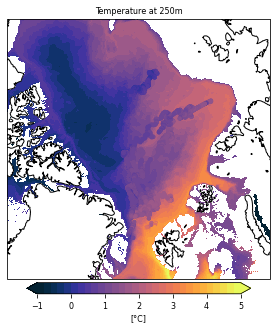

In [37]:
# Define your custom boundaries
bmin = -1
bmax = 5
dstep = .2
bounds = np.arange(bmin,bmax+dstep,dstep).tolist()
cmap = discrete_cmap(len(bounds)-1,cmocean.cm.thermal)
norm = BoundaryNorm(bounds, cmap.N)


cm2in = 1/2.54  # centimeters in inches
figsize = (9.5*cm2in, 11.5*cm2in) #1/4 page

fig, ax = plt.subplots(
    1,
    1,
    subplot_kw=dict(projection=ccrs.NorthPolarStereo()),
    constrained_layout=True,
    figsize=figsize,
)
ax.set_extent([-180, 180, 75, 90], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')

# Use the custom colormap and BoundaryNorm
image = ax.pcolormesh(
    xx_pol, yy_pol, T_grid, cmap=cmap, norm=norm, shading='auto', transform=ccrs.PlateCarree()
)

ind_time = (year_ITP>2014)&(year_ITP<2021)
ind_depth = Depth_reg==depth

lon_tmp = lon_ITP[ind_time]
lat_tmp = lat_ITP[ind_time]
T_ITP_dep = T_ITP[ind_time,ind_depth]

#ax.plot(lon_ITP[ind_time],lat_ITP[ind_time],'k.',transform=ccrs.PlateCarree())
scatter = ax.scatter(lon_ITP[ind_time],lat_ITP[ind_time], c=T_ITP_dep, cmap=cmap, norm=norm, s=10, zorder=2, transform=ccrs.PlateCarree())

cb = fig.colorbar(image, orientation="horizontal", ax=ax, pad=0.01, shrink=0.85, extend='both')
cb.ax.tick_params()
cb.set_label('[°C]')
cb.ax.set_xscale('linear')

ax.set_title('Temperature at '+str(depth)+'m')
fig.savefig((plot_path + '/temp_map_'+str(depth)+'m.png'), dpi=400, format='png',bbox_inches='tight',pad_inches=0,facecolor='white')

In [71]:
for rr,region in enumerate(['web','eeb']):
    
    reg = regs[rr]
    ind_reg = in_reg(reg,lon_ITP,lat_ITP)    
    lon_profs = lon_ITP[ind_reg]
    print(region+str(sum(ind_reg)))

web2471
eeb2759


/tmp/ipykernel_6508/2924486510.py:23: RuntimeWarning: Mean of empty slice
  y_prof = np.nanmean(T_profs,axis=0)
/p/project/chhb19/mueller29/miniconda3/envs/pyfesom2/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_6508/2924486510.py:36: RuntimeWarning: Mean of empty slice
  y = np.nanmean(T_profs,axis=1)
/tmp/ipykernel_6508/2924486510.py:23: RuntimeWarning: Mean of empty slice
  y_prof = np.nanmean(T_profs,axis=0)
/p/project/chhb19/mueller29/miniconda3/envs/pyfesom2/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_6508/2924486510.py:36: RuntimeWarning: Mean of empty slice
  y = np.nanmean(T_profs,axis=1)


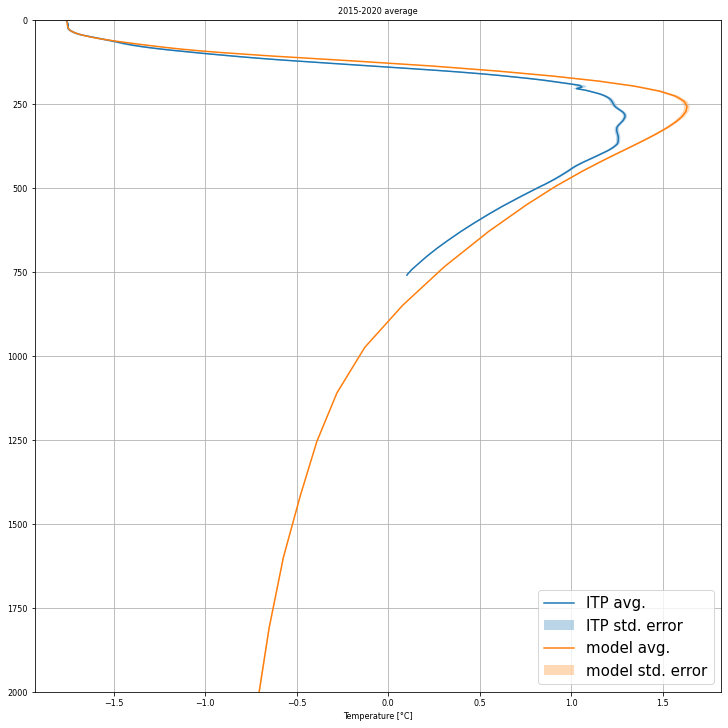

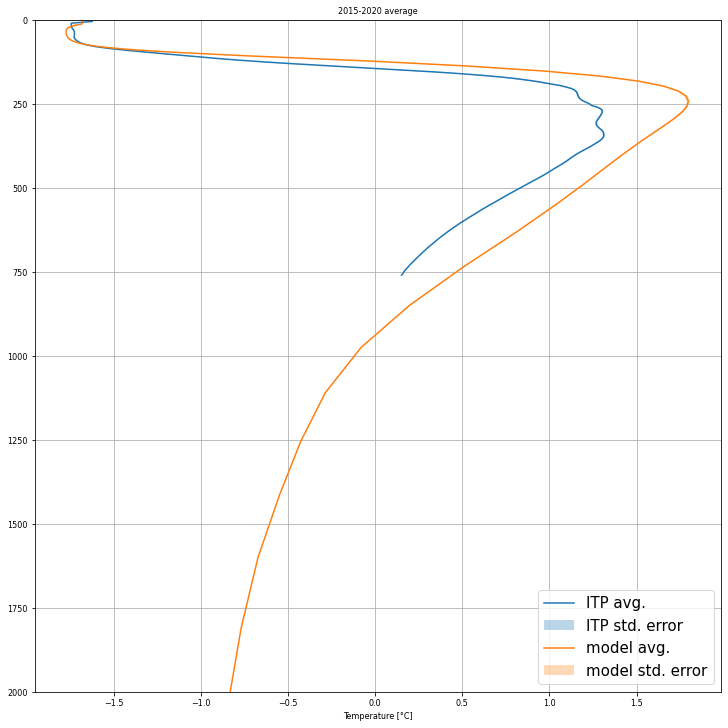

In [66]:
for rr,region in enumerate(['web','eeb']):
    
    reg = regs[rr]
    ind_reg = in_reg(reg,lon_ITP,lat_ITP)    
    lon_profs = lon_ITP[ind_reg]
    lat_profs = lat_ITP[ind_reg]
    T_profs = T_ITP[ind_reg,:]
    months_profs = months_ITP[ind_reg]
    
    dists,inds = create_indexes_and_distances(model_lons,model_lats,lon_profs,lat_profs,1,n_cores)
    
    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        T_tmp_np = T_all[:,:,inds].values

    T_tmp_np_months = np.ones([6,T_tmp_np.shape[1],T_tmp_np.shape[2]])
    for ii in range(len(months_profs)):
        ind_months = (time_all.dt.month == months_profs[ii]).values.ravel()
        T_tmp_np_months = T_tmp_np[ind_months,:,:]
    array_shape = T_tmp_np_months.shape
    T_tmp_np_months = T_tmp_np_months.transpose(1, 0, 2).reshape(array_shape[1], -1)


    y_prof = np.nanmean(T_profs,axis=0)
    err_prof = np.nanstd(T_profs,axis=0)

    y_model = np.nanmean(T_tmp_np_months,axis=1)
    err_model = np.nanstd(T_tmp_np_months,axis=1)

    figsize=(10,10)
    fig, ax = plt.subplots(
            1,
            1,
            constrained_layout=True,
            figsize=figsize,
        )
    y = np.nanmean(T_profs,axis=1)

    line1=ax.plot(y_prof,Depth_reg,label='ITP avg.')
    ax.fill_betweenx(Depth_reg, y_prof-err_prof, y_prof+err_prof, alpha=0.3, label='ITP std.')
    line2=ax.plot(y_model,z1,label='model avg.')
    ax.fill_betweenx(z1, y_model-err_model, y_model+err_model, alpha=0.3, label='model std.')

    ax.invert_yaxis()
    ax.set_ylim([2000, 0])
    ax.grid()
    ax.set_xlabel('Temperature [°C]')
    ax.set_title('2015-2020 average')
    ax.legend(loc='lower right',fontsize=15)
    fig.savefig(plot_path + 'T_compare_ITP_'+region+'_all.png', dpi=400, format='png',bbox_inches='tight',pad_inches=0,facecolor='white')  
    
    

/tmp/ipykernel_6508/1300979810.py:33: RuntimeWarning: Mean of empty slice
  y_prof = np.nanmean(T_profs,axis=0)
/p/project/chhb19/mueller29/miniconda3/envs/pyfesom2/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_6508/1300979810.py:39: RuntimeWarning: Mean of empty slice
  y = np.nanmean(T_profs,axis=1)
/tmp/ipykernel_6508/1300979810.py:33: RuntimeWarning: Mean of empty slice
  y_prof = np.nanmean(T_profs,axis=0)
/p/project/chhb19/mueller29/miniconda3/envs/pyfesom2/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_6508/1300979810.py:39: RuntimeWarning: Mean of empty slice
  y = np.nanmean(T_profs,axis=1)


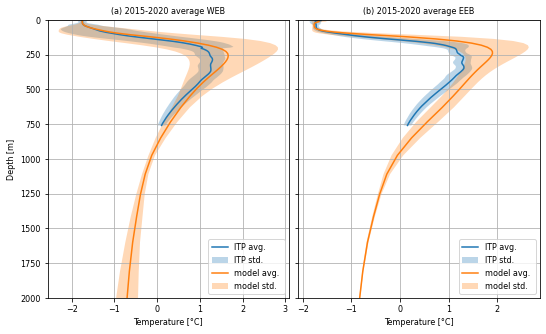

In [107]:
cm2in = 1/2.54  # centimeters in inches
figsize = (19*cm2in, 11.5*cm2in) #1/4 page

fig, axs = plt.subplots(
        1,
        2,
        constrained_layout=True,
        figsize=figsize,
        sharey=True)
ab =['(a) ','(b) ']
for rr,region in enumerate(['WEB','EEB']):
    
    reg = regs[rr]
    ind_reg = in_reg(reg,lon_ITP,lat_ITP)    
    lon_profs = lon_ITP[ind_reg]
    lat_profs = lat_ITP[ind_reg]
    T_profs = T_ITP[ind_reg,:]
    months_profs = months_ITP[ind_reg]
    
    dists,inds = create_indexes_and_distances(model_lons,model_lats,lon_profs,lat_profs,1,n_cores)
    inds = np.unique(inds)
    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        T_tmp_np = T_all[:,:,inds].values

    T_tmp_np_months = np.ones([6,T_tmp_np.shape[1],T_tmp_np.shape[2]])
    for ii in range(len(months_profs)):
        ind_months = (time_all.dt.month == months_profs[ii]).values.ravel()
        T_tmp_np_months = T_tmp_np[ind_months,:,:]
    array_shape = T_tmp_np_months.shape
    T_tmp_np_months = T_tmp_np_months.transpose(1, 0, 2).reshape(array_shape[1], -1)


    y_prof = np.nanmean(T_profs,axis=0)
    err_prof = np.nanstd(T_profs,axis=0)
    #err_prof1,err_prof2 = np.nanpercentile(T_profs, [10,90], axis=0)
    y_model = np.nanmean(T_tmp_np_months,axis=1)
    err_model = np.nanstd(T_tmp_np_months,axis=1)
    #err_model1,err_model2 = np.nanpercentile(T_tmp_np_months, [10,90], axis=1)
    y = np.nanmean(T_profs,axis=1)
    
    ax = axs[rr]
    line1=ax.plot(y_prof,Depth_reg,label='ITP avg. ')
    ax.fill_betweenx(Depth_reg, y_prof-err_prof, y_prof+err_prof, alpha=0.3, label='ITP std.')
    #ax.fill_betweenx(Depth_reg, err_prof1, err_prof2, alpha=0.3, label='ITP std.')
    
    line2=ax.plot(y_model,z1,label='model avg. ')
    ax.fill_betweenx(z1, y_model-err_model, y_model+err_model, alpha=0.3, label='model std.')
    #ax.fill_betweenx(z1, err_model1, err_model2, alpha=0.3, label='model std.')
    
    ax.invert_yaxis()
    ax.set_ylim([2000, 0])
    ax.grid()
    ax.set_xlabel('Temperature [°C]')
    ax.set_title(ab[rr]+'2015-2020 average '+region)
    ax.legend(loc='lower right',fontsize=SMALL_SIZE)
    
    axs[0].set_ylabel('Depth [m]')
    
    fig.savefig(plot_path + 'T_compare_ITP_all.png', dpi=400, format='png',bbox_inches='tight',pad_inches=0,facecolor='white')  

In [15]:
del T_all, T_tmp_np_months, T_tmp_np

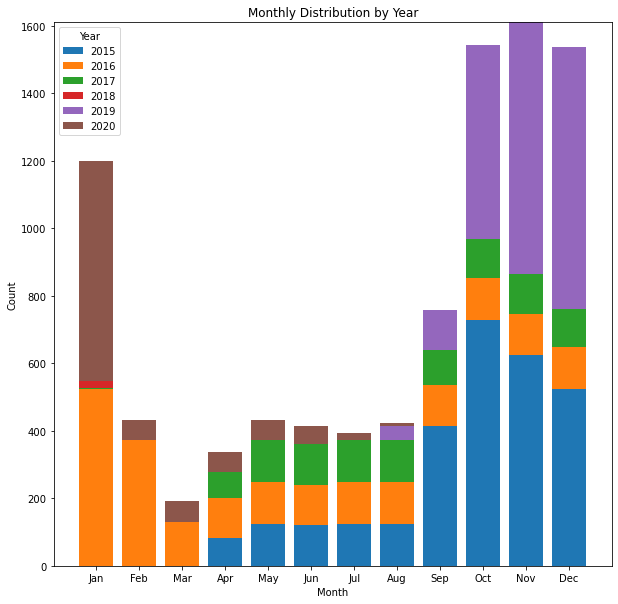

In [16]:
# Create a dictionary to count the occurrences of each month for each year
month_counts = defaultdict(lambda: np.zeros(12, dtype=int))

for date in dates_ITP:
    year_ = date.year
    month_ = date.month
    month_counts[year_][month_ - 1] += 1

# Create a stacked bar plot
figsize=(10,10)

fig, ax = plt.subplots(1,
                       1,
                       figsize=figsize)

#years = list(month_counts.keys())
years = sorted(list(month_counts.keys()))  # Sort the years

months = list(range(1, 13))
bottom = np.zeros(12)

for year_ in years:
    counts = month_counts[year_]
    ax.bar(months, counts, label=str(year_), bottom=bottom)
    bottom += counts

# Set labels and legend
ax.set_xlabel('Month')
ax.set_ylabel('Count')
ax.set_title('Monthly Distribution by Year')
ax.set_xticks(months)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.legend(title='Year')

fig.savefig(plot_path + 'ITP_times.png', dpi=400, format='png',bbox_inches='tight',pad_inches=0)

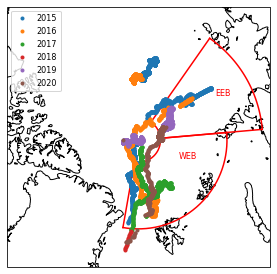

In [31]:
cm2in = 1/2.54  # centimeters in inches
figsize = (9.5*cm2in, 11.5*cm2in) #1/4 page
fig, ax = plt.subplots(
            1,
            1,
            subplot_kw=dict(projection=ccrs.NorthPolarStereo()),
            constrained_layout=True,
            figsize=figsize,
        )
plot_reg(reg_eeb)
plot_reg(reg_web)
ax.text(65,85,'WEB',color='r',transform=ccrs.PlateCarree())
ax.text(120,80,'EEB',color='r',transform=ccrs.PlateCarree())


ax.set_extent([-180,180,75,90], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')

for yy in range(2015,2021):
    idx = year_ITP==yy
    lon_tmp = lon_ITP[idx]
    lat_tmp = lat_ITP[idx]
    
    ax.plot(lon_tmp,lat_tmp,'.',transform=ccrs.PlateCarree(),label=str(yy))

ax.legend(loc='upper left')
fig.savefig(plot_path + 'map_ITP.png', dpi=400, format='png',bbox_inches='tight',pad_inches=0)

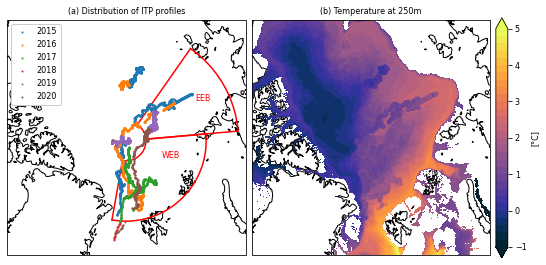

In [82]:
# Define your custom boundaries
bmin = -1
bmax = 5
dstep = .2
bounds = np.arange(bmin,bmax+dstep,dstep).tolist()
cmap = discrete_cmap(len(bounds)-1,cmocean.cm.thermal)
norm = BoundaryNorm(bounds, cmap.N)

cm2in = 1/2.54  # centimeters in inches
figsize = (19*cm2in, 11.5*cm2in) #1/4 page

fig, axs = plt.subplots(
    1,
    2,
    subplot_kw=dict(projection=ccrs.NorthPolarStereo()),
    constrained_layout=True,
    figsize=figsize,
)
ax=axs[1]
ax.set_extent([-180, 180, 75, 90], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')

# Use the custom colormap and BoundaryNorm
image = ax.pcolormesh(
    xx_pol, yy_pol, T_grid, cmap=cmap, norm=norm, shading='auto', transform=ccrs.PlateCarree()
)

ind_time = (year_ITP>2014)&(year_ITP<2021)
ind_depth = Depth_reg==depth

lon_tmp = lon_ITP[ind_time]
lat_tmp = lat_ITP[ind_time]
T_ITP_dep = T_ITP[ind_time,ind_depth]

scatter = ax.scatter(lon_ITP[ind_time],lat_ITP[ind_time], c=T_ITP_dep, cmap=cmap, norm=norm, s=10, zorder=2, transform=ccrs.PlateCarree())

cb = fig.colorbar(image,location='right', ax=ax, pad=0.025, shrink=0.75, extend='both',ticks=np.arange(-1,6,1))
#cb.ax.tick_params()
cb.set_label('[°C]')
cb.ax.set_xscale('linear')
ax.set_title('(b) Temperature at '+str(depth)+'m')

ax=axs[0]
plot_reg(reg_eeb)
plot_reg(reg_web)
ax.text(65,85,'WEB',color='r',transform=ccrs.PlateCarree())
ax.text(120,80,'EEB',color='r',transform=ccrs.PlateCarree())


ax.set_extent([-180,180,75,90], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')

for yy in range(2015,2021):
    idx = year_ITP==yy
    lon_tmp = lon_ITP[idx]
    lat_tmp = lat_ITP[idx]
    
    ax.plot(lon_tmp,lat_tmp,'.',markersize=2,transform=ccrs.PlateCarree(),label=str(yy))

legend=ax.legend(loc='upper left',facecolor='white', framealpha=1)
ax.set_title('(a) Distribution of ITP profiles')

fig.savefig((plot_path + '/maps.png'), dpi=400, format='png',bbox_inches='tight',pad_inches=0,facecolor='white')



In [18]:
client.close()